In [1]:
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from format_param import prettify_param
from matplotlib import rc

In [2]:
prefix = "HH_client_BITP_"
filename = "filtered_logs/client_id_bitp_filtered_combined.txt"
s = open(filename, "r").readlines()    

In [3]:
raw_pr = []
raw_mem = []
raw_time = []
raw_final_mem = []
ln = 0
query_type = ""
flagFinal = False
for line in s:
    if line.startswith("START_OF_FINAL_STATS_REPORT"):
        flagFinal = True
    if line.startswith("Stats request at line"):
        ln = int(re.findall("\d+", line)[1])
        flagFinal = False
    if line.find(" timers") != -1:
        query_type = line.strip().split(" ")[0]
    if line.find(" ms = ") != -1 and flagFinal:
        t = line.strip().split(':')
        if t[0] != "EXACT_HH":
            sketch = t[0].split('-')
            sketch = [sketch[0], ''.join(sketch[1:])]
            raw_time.append(sketch + [ln, query_type, int(t[1].split("=")[1].strip()[:-3])])
    if line.find("prec") != -1:
        t = line.strip().split(':')
        if t[0] != "EXACT_HH":
            sketch = t[0].split('-')
            sketch = [sketch[0], ''.join(sketch[1:])]
            pr_info = t[1].split(",")
            try:
                pr_info = list(map(lambda x: float(x.split('=')[2].strip()), pr_info))
            except ZeroDivisionError:
                continue
            raw_pr.append(sketch + [pr_info[0], pr_info[1]])
    if line.find("MB") != -1:
        t = line.strip().split(':')
        if t[0] != "EXACT_HH":
            sketch = t[0].split('-')
            s_param = ''.join(sketch[1:])
            if sketch[0] == "SAMPLING_BITP" or sketch[0] == "TMG_BITP":
                if s_param.endswith("_max"):
                    s_param = s_param[:-4]
                else:
                    continue
            t = [sketch[0], s_param, ln, int(t[1].split("=")[0].strip()[:-2])]
            if flagFinal:
                raw_final_mem.append(t)
            else:
                raw_mem.append(t)

In [4]:
mem = pd.DataFrame(raw_mem, columns = ["Sketch", "Param", "Stream Size", "Memory Usage (B)"])
mem

,Sketch,Param,Stream Size,Memory Usage (B)
0,PCM_HH,logU22e0.0003d0.01D2000,13528041,159072432
1,SAMPLING_BITP,ss10000use_new_impl2,13528041,10885056
2,PCM_HH,logU22e0.0003d0.01D2000,27056082,163710512
3,SAMPLING_BITP,ss10000use_new_impl2,27056082,11525056
4,PCM_HH,logU22e0.0003d0.01D2000,40584123,168190512
...,...,...,...,...
1788,TMG_BITP,e0.000100,1298691936,10452224904
1789,TMG_BITP,e0.000100,1312219977,10452220824
1790,TMG_BITP,e0.000100,1325748018,10452220696
1791,TMG_BITP,e0.000100,1339276059,10452219864


In [5]:
final_mem = pd.DataFrame(raw_final_mem, columns = ["Sketch", "Param", "Stream Size", "Memory Usage (B)"])
final_mem

,Sketch,Param,Stream Size,Memory Usage (B)
0,PCM_HH,logU22e0.0003d0.01D2000,1352804100,859612016
1,SAMPLING_BITP,ss10000use_new_impl2,1352804100,14085056
2,PCM_HH,logU22e0.0006d0.01D2000,1352804100,787823168
3,SAMPLING_BITP,ss25000use_new_impl2,1352804100,35205056
4,PCM_HH,logU22e0.01d0.01D2000,1352804100,524949704
5,SAMPLING_BITP,ss50000use_new_impl2,1352804100,70405056
6,PCM_HH,logU22e0.005d0.01D2000,1352804100,593686856
7,SAMPLING_BITP,ss100000use_new_impl2,1352804100,140805056
8,PCM_HH,logU22e0.001d0.01D2000,1352804100,746891648
9,SAMPLING_BITP,ss500000use_new_impl2,1352804100,704005056


In [6]:
time = pd.DataFrame(raw_time, columns = ["Sketch", "Param", "Stream Size", "Type", "Time (ms)"])
time_processed = pd.merge(time, final_mem, on = ["Sketch", "Param", "Stream Size"]).drop(["Stream Size", "Param"], 1).drop_duplicates()
utime = time_processed[time_processed["Type"] == "Update"]
qtime = time_processed[time_processed["Type"] == "Query"]
qtime

<ipython-input-6-44ad82669181>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  time_processed = pd.merge(time, final_mem, on = ["Sketch", "Param", "Stream Size"]).drop(["Stream Size", "Param"], 1).drop_duplicates()


,Sketch,Type,Time (ms),Memory Usage (B)
1,PCM_HH,Query,165,859612016
3,SAMPLING_BITP,Query,324,14085056
5,PCM_HH,Query,727,787823168
7,SAMPLING_BITP,Query,1143,35205056
9,PCM_HH,Query,27578,524949704
11,SAMPLING_BITP,Query,2709,70405056
13,PCM_HH,Query,29738,593686856
15,SAMPLING_BITP,Query,6406,140805056
17,PCM_HH,Query,27219,746891648
19,SAMPLING_BITP,Query,34241,704005056


In [7]:
utime

,Sketch,Type,Time (ms),Memory Usage (B)
0,PCM_HH,Update,9249761,859612016
2,SAMPLING_BITP,Update,877078,14085056
4,PCM_HH,Update,8818753,787823168
6,SAMPLING_BITP,Update,867441,35205056
8,PCM_HH,Update,6702015,524949704
10,SAMPLING_BITP,Update,871436,70405056
12,PCM_HH,Update,7144583,593686856
14,SAMPLING_BITP,Update,883146,140805056
16,PCM_HH,Update,8552231,746891648
18,SAMPLING_BITP,Update,919660,704005056


In [8]:
raw_pr

[['PCM_HH', 'logU22e0.0003d0.01D2000', 0.426434, 1.0],
 ['SAMPLING_BITP', 'ss10000use_new_impl2', 0.5, 0.614035],
 ['PCM_HH', 'logU22e0.0003d0.01D2000', 0.45122, 1.0],
 ['SAMPLING_BITP', 'ss10000use_new_impl2', 0.584615, 0.616216],
 ['PCM_HH', 'logU22e0.0003d0.01D2000', 0.445701, 1.0],
 ['SAMPLING_BITP', 'ss10000use_new_impl2', 0.568807, 0.629442],
 ['PCM_HH', 'logU22e0.0003d0.01D2000', 0.468144, 1.0],
 ['SAMPLING_BITP', 'ss10000use_new_impl2', 0.570707, 0.668639],
 ['PCM_HH', 'logU22e0.0003d0.01D2000', 0.414698, 1.0],
 ['SAMPLING_BITP', 'ss10000use_new_impl2', 0.5, 0.582278],
 ['PCM_HH', 'logU22e0.0006d0.01D2000', 0.0278774, 1.0],
 ['SAMPLING_BITP', 'ss25000use_new_impl2', 0.675676, 0.730994],
 ['PCM_HH', 'logU22e0.0006d0.01D2000', 0.0314305, 1.0],
 ['SAMPLING_BITP', 'ss25000use_new_impl2', 0.71123, 0.718919],
 ['PCM_HH', 'logU22e0.0006d0.01D2000', 0.0245636, 1.0],
 ['SAMPLING_BITP', 'ss25000use_new_impl2', 0.688679, 0.741117],
 ['PCM_HH', 'logU22e0.0006d0.01D2000', 0.0244184, 1.0],
 

In [11]:
pr = pd.DataFrame(raw_pr, columns = ["Sketch", "Param", "Precision", "Recall"])
pr = pd.merge(pr, final_mem, on = ["Sketch", "Param"]).groupby(["Sketch", "Param", "Memory Usage (B)"]).mean().drop("Stream Size", 1)
pr = pd.DataFrame(pr.to_records())
pr

<ipython-input-11-bac393d7308a>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  pr = pd.merge(pr, final_mem, on = ["Sketch", "Param"]).groupby(["Sketch", "Param", "Memory Usage (B)"]).mean().drop("Stream Size", 1)


,Sketch,Param,Memory Usage (B),Precision,Recall
0,PCM_HH,logU22e0.0003d0.01D2000,859612016,0.441239,1.000000
1,PCM_HH,logU22e0.0006d0.01D2000,787823168,0.026233,1.000000
2,PCM_HH,logU22e0.001d0.01D2000,746891648,0.000099,1.000000
3,PCM_HH,logU22e0.002d0.01D2000,656750344,0.000065,1.000000
4,PCM_HH,logU22e0.005d0.01D2000,593686856,0.000064,1.000000
5,PCM_HH,logU22e0.01d0.01D2000,524949704,0.000063,1.000000
6,SAMPLING_BITP,ss1000000use_new_impl2,1344005056,0.945814,0.949450
7,SAMPLING_BITP,ss100000use_new_impl2,140805056,0.855788,0.872944
8,SAMPLING_BITP,ss10000use_new_impl2,14085056,0.544826,0.622122
9,SAMPLING_BITP,ss25000use_new_impl2,35205056,0.683718,0.730439


[['SAMPLING_BITP' 'SAMPLING_BITP' 'SAMPLING_BITP' 'SAMPLING_BITP'
  'SAMPLING_BITP' 'SAMPLING_BITP']
 ['ss10000use_new_impl2' 'ss25000use_new_impl2' 'ss50000use_new_impl2'
  'ss100000use_new_impl2' 'ss500000use_new_impl2'
  'ss1000000use_new_impl2']
 [14085056 35205056 70405056 140805056 704005056 1344005056]
 [0.5448258 0.683718 0.7763572 0.8557884 0.9298878 0.945814]
 [0.622122 0.7304388 0.8320396000000001 0.8729435999999999
  0.9455370000000001 0.9494503999999999]]
[['TMG_BITP' 'TMG_BITP' 'TMG_BITP' 'TMG_BITP' 'TMG_BITP' 'TMG_BITP']
 ['e0.000200' 'e0.000100' 'e0.000070' 'e0.000050' 'e0.000030' 'e0.000010']
 [7458528568 10452219656 12272641328 14995086088 18757350992 30555391288]
 [0.3252918 0.633814 0.7330180000000001 0.7974914 0.8783683999999999
  0.9519287999999999]
 [1.0 1.0 1.0 1.0 1.0 0.9959389999999999]]
[['PCM_HH' 'PCM_HH' 'PCM_HH' 'PCM_HH' 'PCM_HH' 'PCM_HH']
 ['logU22e0.01d0.01D2000' 'logU22e0.005d0.01D2000'
  'logU22e0.002d0.01D2000' 'logU22e0.001d0.01D2000'
  'logU22e0.000

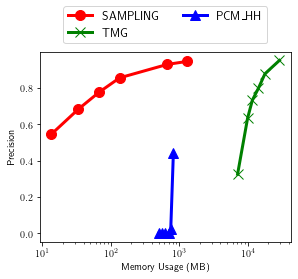

In [12]:
fig, ax = plt.subplots(figsize = (4.5, 3.5))
sketch_type = ["SAMPLING_BITP", "TMG_BITP", "PCM_HH"]
   
linestyles = ["-", "--", "."]
colors = ["r", "g", "b"]
markers = ["o", "x", "^"]
ms = 10
lw = 3

cnt = 0
for sk in sketch_type:
    dat = pr[pr["Sketch"] == sk].sort_values(by = "Memory Usage (B)").transpose().to_numpy()
    print(dat)
    plt.plot(dat[2] / 1048576.0, dat[3], color = colors[cnt], marker = markers[cnt],
             label = (sk.endswith("_BITP") and sk.split('_')[0] or sk.replace('_', '\\_')),
             markersize = ms, linewidth = lw)
    cnt += 1
    
lgd = ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.27), ncol=2, fontsize=12)
ax.set_xscale("log")
ax.set_xlabel("Memory Usage (MB)")
ax.set_ylabel("Precision")
#plt.tight_layout()
plt.savefig(prefix + 'precision.pdf', bbox_extra_artists=[lgd], bbox_inches='tight')

[['SAMPLING_BITP' 'SAMPLING_BITP' 'SAMPLING_BITP' 'SAMPLING_BITP'
  'SAMPLING_BITP' 'SAMPLING_BITP']
 ['ss10000use_new_impl2' 'ss25000use_new_impl2' 'ss50000use_new_impl2'
  'ss100000use_new_impl2' 'ss500000use_new_impl2'
  'ss1000000use_new_impl2']
 [14085056 35205056 70405056 140805056 704005056 1344005056]
 [0.5448258 0.683718 0.7763572 0.8557884 0.9298878 0.945814]
 [0.622122 0.7304388 0.8320396000000001 0.8729435999999999
  0.9455370000000001 0.9494503999999999]]
[['TMG_BITP' 'TMG_BITP' 'TMG_BITP' 'TMG_BITP' 'TMG_BITP' 'TMG_BITP']
 ['e0.000200' 'e0.000100' 'e0.000070' 'e0.000050' 'e0.000030' 'e0.000010']
 [7458528568 10452219656 12272641328 14995086088 18757350992 30555391288]
 [0.3252918 0.633814 0.7330180000000001 0.7974914 0.8783683999999999
  0.9519287999999999]
 [1.0 1.0 1.0 1.0 1.0 0.9959389999999999]]
[['PCM_HH' 'PCM_HH' 'PCM_HH' 'PCM_HH' 'PCM_HH' 'PCM_HH']
 ['logU22e0.01d0.01D2000' 'logU22e0.005d0.01D2000'
  'logU22e0.002d0.01D2000' 'logU22e0.001d0.01D2000'
  'logU22e0.000

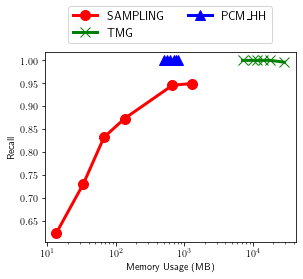

In [14]:
fig, ax = plt.subplots(figsize = (4.5, 3.5))
cnt = 0
for sk in sketch_type:
    dat = pr[pr["Sketch"] == sk].sort_values(by = "Memory Usage (B)").transpose().to_numpy()
    print(dat)
    plt.plot(dat[2] / 1048576.0, dat[4], color = colors[cnt], marker = markers[cnt],
             label = (sk.endswith("_BITP") and sk.split('_')[0] or sk.replace('_', '\\_')),
             markersize = ms, linewidth = lw)
    cnt += 1

lgd = ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.27), ncol=2, fontsize=12)
ax.set_xscale("log")
ax.set_xlabel("Memory Usage (MB)")
ax.set_ylabel("Recall")
#plt.tight_layout()
plt.savefig(prefix + 'recall.pdf', bbox_extra_artists=[lgd], bbox_inches='tight')

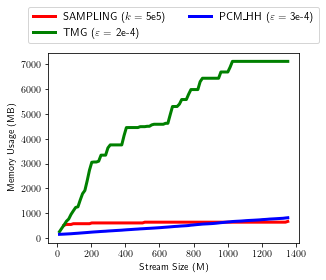

In [15]:
fig, ax = plt.subplots(figsize = (4.5, 3.5))
cnt = 0
sketch_param = {
    "PCM_HH" : ["logU22e0.0003d0.01D2000"],
    "SAMPLING_BITP" : ["ss500000use_new_impl2"],
    "TMG_BITP" : ["e0.000200"],
}

for sk in sketch_type:
    cnt0 = 0
    for p in sketch_param[sk]:
        dat = mem[(mem["Sketch"] == sk) & (mem["Param"] == p)].sort_values(by = "Stream Size").transpose().to_numpy()
        plt.plot(dat[2] / 1000000.0, dat[3] / 1048576.0,
                 label = "%s %s" % (sk.endswith("_BITP") and sk.split('_')[0] or sk.replace('_', '\\_'), prettify_param(p)),
                 markersize = ms, color = colors[cnt], linestyle = linestyles[cnt0], linewidth = lw)
        cnt0 += 1
    cnt += 1

lgd = ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.27), ncol=2, fontsize=11)

#ax.set_yscale("log")
ax.set_xlabel("Stream Size (M)")
ax.set_ylabel("Memory Usage (MB)")
#plt.tight_layout()
plt.savefig(prefix + 'mem.pdf', bbox_extra_artists=[lgd], bbox_inches='tight')

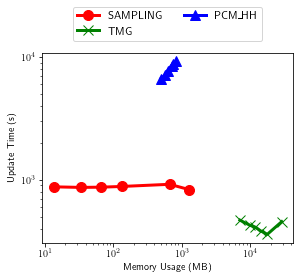

In [16]:
fig, ax = plt.subplots(figsize = (4.5, 3.5))
cnt = 0
for sk in sketch_type:
    dat = utime[utime["Sketch"] == sk].sort_values(by = "Memory Usage (B)").transpose().to_numpy()
    plt.plot(dat[-1] / 1048576.0, dat[-2]/1000.0, color = colors[cnt], marker = markers[cnt],
             label = (sk.endswith("_BITP") and sk.split('_')[0] or sk.replace('_', '\\_')),
             markersize = ms, linewidth = lw)
    cnt += 1

lgd = ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.27), ncol=2, fontsize=11)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Memory Usage (MB)")
ax.set_ylabel("Update Time (s)")
#plt.tight_layout()
plt.savefig(prefix + 'utime.pdf', bbox_extra_artists=[lgd], bbox_inches='tight')

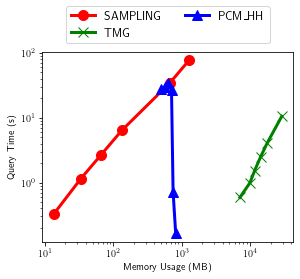

In [17]:
fig, ax = plt.subplots(figsize = (4.5, 3.5))
cnt = 0
for sk in sketch_type:
    dat = qtime[qtime["Sketch"] == sk].sort_values(by = "Memory Usage (B)").transpose().to_numpy()
    plt.plot(dat[-1] / 1048576.0, dat[-2]/1000.0, color = colors[cnt], marker = markers[cnt],
             label = (sk.endswith("_BITP") and sk.split('_')[0] or sk.replace('_', '\\_')),
             markersize = ms, linewidth = lw)
    cnt += 1

lgd = ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.27), ncol=2, fontsize=12)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Memory Usage (MB)")
ax.set_ylabel("Query Time (s)")
#plt.tight_layout()
plt.savefig(prefix + 'qtime.pdf', bbox_extra_artists=[lgd], bbox_inches='tight')